In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import transforms, utils
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix, recall_score, accuracy_score
from skimage.measure import EllipseModel, find_contours
from skimage.draw import ellipse
import nibabel as nib
import SimpleITK as sitk
import numpy as np
import seaborn as sns
from scipy import ndimage, spatial, special
import scipy.optimize as optimize
import os
from radiomics import featureextractor
import radiomics
import numpy as np
import pandas as pd
import math
import datatable as dt
from skimage import io, transform
import seaborn as sns
import pickle
from torch.utils.data import DataLoader, Dataset
import glob
from PIL import Image
%matplotlib widget
import matplotlib.pyplot as plt

In [28]:
try:
    num_gpus = torch.cuda.device_count()
    print("Number of GPUs available:", num_gpus)
    for i in range(num_gpus):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
except Exception as e:
    print("Error while checking GPUs:", e)

Number of GPUs available: 3
GPU 0: NVIDIA RTX A6000
GPU 1: NVIDIA RTX A6000
GPU 2: NVIDIA RTX A6000


In [29]:
print(torch.cuda.is_available())

True


In [30]:
device = torch.device("cuda:1")

In [31]:
class AxialCutsDataset(Dataset):

    def __init__(self, data_shape, transform=None, for_trainning=False, mean=False, std=False, downsample=False):
        self.data = data_shape
        self.transform=transform
        self.for_trainning = for_trainning
        self.mean= mean
        self.std = std
        self.downsample = downsample

        if self.downsample:
            df_majority = self.data[self.data.iloc[:, 1]=='Irregular']
            df_majority_downsampled = resample(df_majority, replace=False, n_samples=1200, random_state=125)
            self.data = pd.concat((self.data[self.data['Shape'] != 'Irregular'], df_majority_downsampled))

    def __len__(self):
        return len(self.data.iloc[:, 0])

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        img_name = self.data.iloc[idx, 0]
        image = io.imread(img_name)
        shape = self.data.iloc[idx, 1]
        sample = {'image': image, 'shape': shape}

        if self.transform:
            sample = self.transform(sample)

        return sample
        


In [32]:
def show_image(image):
    plt.imshow(image, vmin = 0, vmax = 255, cmap='grey')

0 (51, 51) Ambiguous
1 (51, 51) Ambiguous
2 (51, 51) Ambiguous
3 (51, 51) Ambiguous
4 (51, 51) Ambiguous
5 (51, 51) Ambiguous
6 (51, 51) Ambiguous


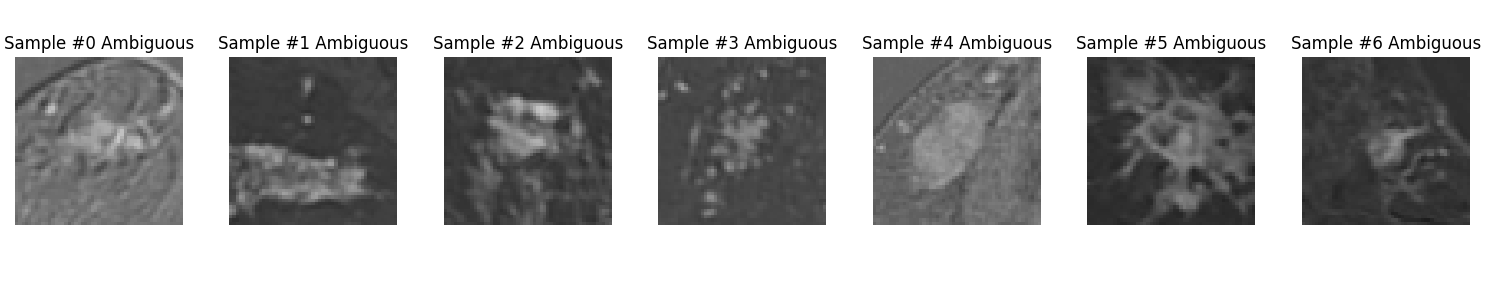

In [33]:
images_path = '/mnt/data/psteinmetz/neotex/data_CNN/images_15062024/'
data = pd.concat(
    (
        pd.DataFrame(glob.glob(f'{images_path}*/*png')),
        pd.DataFrame(
            [x.split('/')[-1][:-4] for x in glob.glob(f'{images_path}*/*png')]
        ),
        pd.DataFrame(
            [k.split('/')[-2] for k in glob.glob(f'{images_path}*/*png')]
        ),
    ),
    axis=1,
)
data.columns = ['Path', 'ID', 'Shape']
data.set_index('ID', inplace=True)
axialcuts_dataset = AxialCutsDataset(data_shape=data, downsample=True)

fig = plt.figure(figsize=(15, 3))

for i, sample in enumerate(axialcuts_dataset):
    sh= sample['shape']
    print(i, sample['image'].shape, sh)

    ax = plt.subplot(1, 7, i + 1)
    plt.tight_layout()
    ax.set_title(f'Sample #{i} {sh}')
    ax.axis('off')
    show_image(sample['image'])

    if i == 6:
        break

In [34]:
path_to_csv = r'/mnt/data/psteinmetz/neotex/CSV/BOUNDING_BOX.csv'
data_train = dt.fread(path_to_csv).to_pandas()
shape_target_train = pd.concat((data_train[['Record_ID']], data_train[['Shape.1']]), axis=1)
shape_modified = shape_target_train.replace('Oval', 'Round')

In [35]:
shape_modified.set_index('Record_ID', inplace=True)

In [36]:
list_cases, index = np.unique((pd.DataFrame(axialcuts_dataset.data.index)['ID'].apply(lambda x: x.split('_')[0])), return_index=True)

In [37]:
X = list_cases

In [38]:
y = np.array(shape_modified['Shape.1'])

In [39]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)

In [40]:
for i, (train_index, test_index) in enumerate(skf.split(X, y)):

    print(f"Fold {i}:")
    print(f"  Train: index={shape_modified.iloc[train_index]['Shape.1'].value_counts()}")

    print(f"  Test:  index={shape_modified.iloc[test_index]['Shape.1'].value_counts()}")

Fold 0:
  Train: index=Shape.1
Irregular    60
Round        22
Name: count, dtype: int64
  Test:  index=Shape.1
Irregular    16
Round         5
Name: count, dtype: int64
Fold 1:
  Train: index=Shape.1
Irregular    61
Round        21
Name: count, dtype: int64
  Test:  index=Shape.1
Irregular    15
Round         6
Name: count, dtype: int64
Fold 2:
  Train: index=Shape.1
Irregular    61
Round        21
Name: count, dtype: int64
  Test:  index=Shape.1
Irregular    15
Round         6
Name: count, dtype: int64
Fold 3:
  Train: index=Shape.1
Irregular    61
Round        22
Name: count, dtype: int64
  Test:  index=Shape.1
Irregular    15
Round         5
Name: count, dtype: int64
Fold 4:
  Train: index=Shape.1
Irregular    61
Round        22
Name: count, dtype: int64
  Test:  index=Shape.1
Irregular    15
Round         5
Name: count, dtype: int64


In [41]:
data_without_amb = axialcuts_dataset.data[axialcuts_dataset.data['Shape']!='Ambiguous']

In [42]:
serie = (pd.DataFrame(data_without_amb.index)['ID'].apply(lambda x: x.split('_')[0]))

Shape
Irregular    970
Round        957
Name: count, dtype: int64
Shape
Round        246
Irregular    230
Name: count, dtype: int64


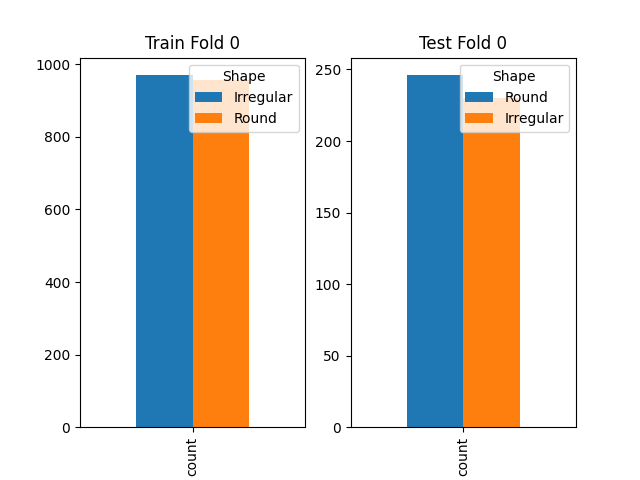

Shape
Round        1041
Irregular     889
Name: count, dtype: int64
Shape
Round        162
Irregular    162
Name: count, dtype: int64


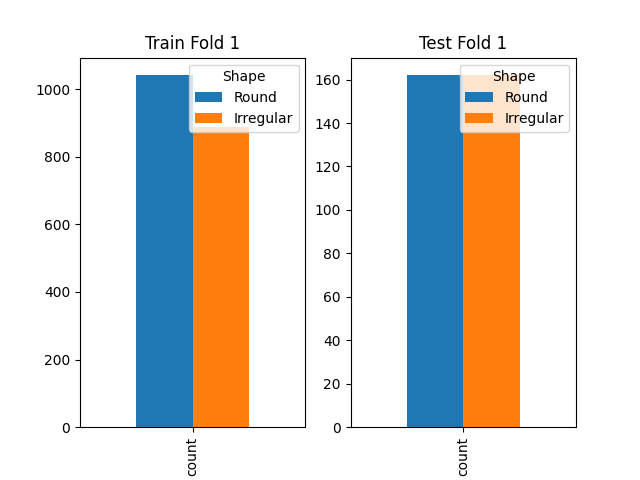

Shape
Round        978
Irregular    953
Name: count, dtype: int64
Shape
Irregular    247
Round        225
Name: count, dtype: int64


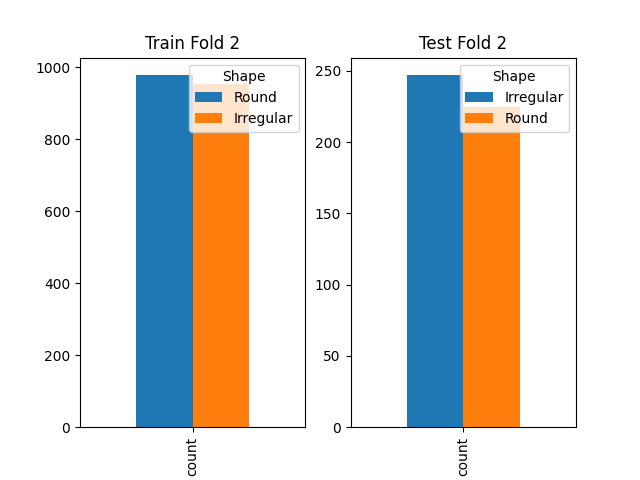

Shape
Round        988
Irregular    979
Name: count, dtype: int64
Shape
Irregular    221
Round        215
Name: count, dtype: int64


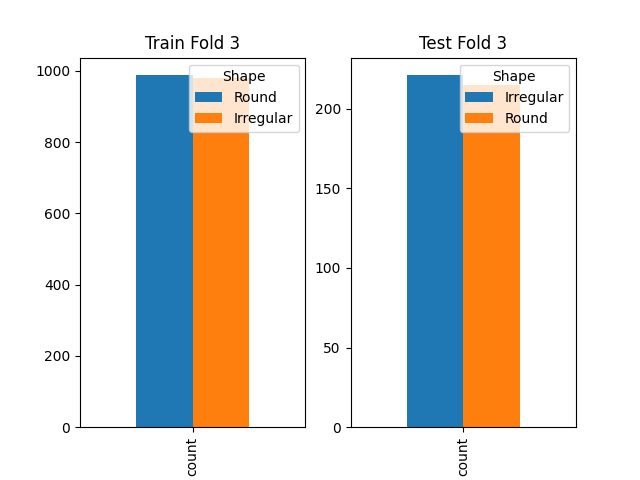

Shape
Irregular    1009
Round         848
Name: count, dtype: int64
Shape
Irregular    191
Round        191
Name: count, dtype: int64


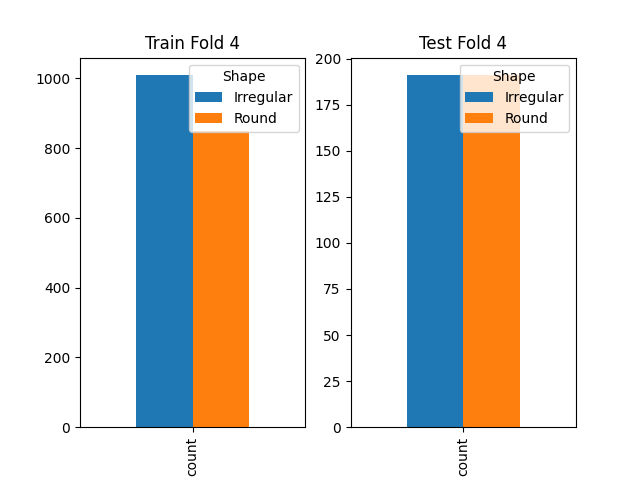

In [43]:
train_folds_index = []
test_folds_index = []
for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    ind_lists_train = [list(serie[serie==k].index[:].ravel()) for k in X[train_index]]
    flat_list_train = [
        x
        for xs in ind_lists_train
        for x in xs
        ]
    train_folds_index.append(flat_list_train)
    ind_lists_test = [list(serie[serie==k].index[:].ravel()) for k in X[test_index]]
    flat_list_test = [
        x
        for xs in ind_lists_test
        for x in xs
    ]
    
    a_train = data_without_amb.iloc[flat_list_train]['Shape'].value_counts().min()
    b_train = data_without_amb.iloc[flat_list_train]['Shape'].value_counts().max()
    
    a_test = data_without_amb.iloc[flat_list_test]['Shape'].value_counts().min()
    b_test = data_without_amb.iloc[flat_list_test]['Shape'].value_counts().max()
    
    if a_test/(a_test + b_test) < 0.4:
        label_maj = data_without_amb.iloc[flat_list_test]['Shape'].value_counts().idxmax()
        label_min = data_without_amb.iloc[flat_list_test]['Shape'].value_counts().idxmin()
        df_majority = data_without_amb.iloc[flat_list_test]['Shape'].loc[data_without_amb.iloc[flat_list_test]['Shape']==label_maj]
        df_majority_downsampled = resample(df_majority, replace=False, n_samples=a_test, random_state=125)
        
        index_list = data_without_amb.iloc[flat_list_test].loc[data_without_amb.iloc[flat_list_test]['Shape']==label_min].index
        row_numbers_min = [data_without_amb.index.get_loc(idx) for idx in index_list]
        
        flat_list_test = row_numbers_min + [data_without_amb.index.get_loc(idx) for idx in df_majority_downsampled.index]
    test_folds_index.append(flat_list_test)
    
    print(data_without_amb.iloc[flat_list_train]['Shape'].value_counts())
    print(data_without_amb.iloc[flat_list_test]['Shape'].value_counts())
    data_train = pd.DataFrame(data_without_amb.iloc[flat_list_train]['Shape'].value_counts())
    data_test = pd.DataFrame(data_without_amb.iloc[flat_list_test]['Shape'].value_counts())
    _, axs = plt.subplots(1, 2)
    data_train.T.plot.bar(title=f'Train Fold {str(i)}', ax=axs[0])
    data_test.T.plot.bar(title=f'Test Fold {str(i)}', ax=axs[1])
    
    plt.show()
    

In [44]:
class ToTensor(object):

    def __call__(self, sample):
        image, shape = sample['image'], sample['shape']
        if shape=='Round':
            shape=0
        elif shape=='Irregular':
            shape=1
        elif shape=='Ambiguous':
            shape=2
        return {'image': torch.from_numpy(image).unsqueeze(0),
                'shape': torch.from_numpy(np.asarray(shape))}

In [45]:
class Normalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std
    def __call__(self, sample):
        image, shape = sample['image'], sample['shape']
        norm = transforms.Normalize(mean=self.mean, std=self.std)
        return {'image': norm(image.float()),
                'shape': shape}

In [46]:
def get_mean_std(loader):
    # Compute the mean and standard deviation of all pixels in the dataset
    num_data = 0
    mean = 0.0
    std = 0.0
    for images in loader:
        batch_size, num_channels, height, width = images['image'].shape
        num_data += 1#batch_size * height * width

        mean += images['image'].float().mean(axis=(0, 2, 3))
        std += images['image'].float().std(axis=(0, 2, 3))
    mean /= num_data
    std /= num_data

    return mean, std

In [47]:
transformed_dataset = AxialCutsDataset(data_shape=data, downsample=True, transform= ToTensor())

In [48]:
for i, sample in enumerate(transformed_dataset):
    print(i, sample['image'].size(), sample['shape'])

    if i == 3:
        break

0 torch.Size([1, 51, 51]) tensor(2)
1 torch.Size([1, 51, 51]) tensor(2)
2 torch.Size([1, 51, 51]) tensor(2)
3 torch.Size([1, 51, 51]) tensor(2)


0 torch.Size([4, 1, 51, 51]) torch.Size([4])
1 torch.Size([4, 1, 51, 51]) torch.Size([4])
2 torch.Size([4, 1, 51, 51]) torch.Size([4])
3 torch.Size([4, 1, 51, 51]) torch.Size([4])
tensor([2, 1, 2, 0])


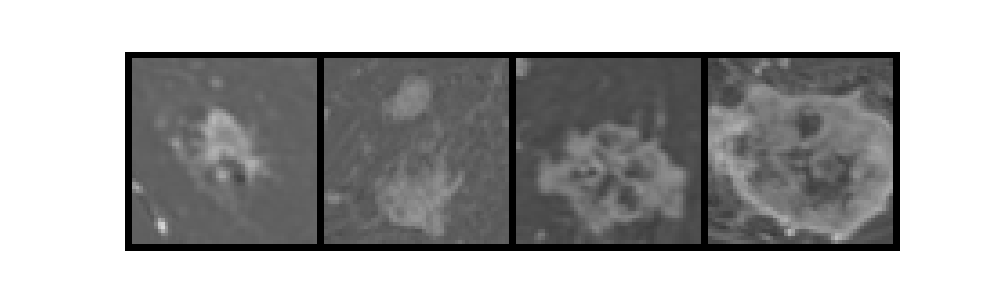

In [49]:
dataloader = DataLoader(transformed_dataset, batch_size=4,
                        shuffle=True, num_workers=0)
for i_batch, sample_batched in enumerate(dataloader):

    print(i_batch, sample_batched['image'].size(), sample_batched['shape'].size())
    if i_batch == 3:
        
        plt.figure(figsize=(10, 3))
        images_batch, label_batch = sample_batched['image'], sample_batched['shape']
        print(label_batch)
        batch_size = len(images_batch)
        im_size = images_batch.size(2)
        grid_border_size = 2
        grid = utils.make_grid(images_batch)

        plt.imshow(grid.numpy().transpose((1, 2, 0)))
        plt.axis('off')
        plt.ioff()
        
        plt.show()
        break

In [50]:
normalized_datasets = []
means = []
stds = []
for fold in range(0, 5):
    
    train_sampler = torch.utils.data.SubsetRandomSampler(train_folds_index[fold])
    test_sampler = torch.utils.data.SubsetRandomSampler(test_folds_index[fold])
    
    new_dataloader = DataLoader(transformed_dataset, batch_size=1, num_workers=7, sampler=train_sampler)
    a=[k['image'] for k in new_dataloader]
    mean = np.mean(a)
    std = np.std(a)
    print(mean)
    print(std)
    means.append(mean)
    stds.append(std)
    data_transforms = transforms.Compose([
    ToTensor(),
    Normalize(mean=mean, std=std)
    ])
    normalized_dataset = AxialCutsDataset(data_shape=data_without_amb, downsample=True, transform= data_transforms)
    normalized_datasets.append(normalized_dataset)
    if fold == 0:
        normalized_dataset_for_viz = AxialCutsDataset(data_shape=data, downsample=True, transform= data_transforms)

87.71388394587767
29.847407867319895
87.23479450908678
29.716897991008246
87.70675740976014
29.901889363106314
87.23883368154323
29.85083562966821
87.21365524257789
29.795374115628988


In [53]:
print(np.mean(means))

87.42158495776914


In [54]:
print(np.mean(stds))

29.82248099334633


In [ ]:
df = pd.DataFrame(normalized_dataset_for_viz.data)

In [ ]:
round_index = np.where(df['Shape']=='Round')[0]
irregular_index = np.where(df['Shape']=='Irregular')[0]
ambiguous_index = np.where(df['Shape']=='Ambiguous')[0]

In [ ]:
round_subsample = torch.utils.data.SubsetRandomSampler(round_index)
irregular_subsample = torch.utils.data.SubsetRandomSampler(irregular_index)
ambiguous_subsample = torch.utils.data.SubsetRandomSampler(ambiguous_index)

In [ ]:
plt.close('all')
vizloader = DataLoader(normalized_dataset_for_viz, batch_size=24, num_workers=0, sampler=irregular_subsample)
minim = min(
    torch.min(normalized_dataset_for_viz[k]['image'])
    for k in range(len(vizloader))
)
maxim = max(
    torch.max(normalized_dataset_for_viz[k]['image'])
    for k in range(len(vizloader))
)
for i_batch, sample_batched in enumerate(vizloader):
    if i_batch == 23:

        plt.figure(figsize=(15, 5))
        images_batch, label_batch = sample_batched['image'], sample_batched['shape']
        print(label_batch)
        batch_size = len(images_batch)

        grid = utils.make_grid(images_batch)

        plt.imshow(((grid.numpy().transpose((1, 2, 0)) - minim.numpy()) / (maxim-minim)), vmin=0, vmax=1)
        plt.title(label_batch)
        plt.axis('off')
        plt.ioff()

        plt.show()
        break

In [ ]:
plt.close('all')
vizloader = DataLoader(normalized_dataset_for_viz, batch_size=24, num_workers=0, sampler=round_subsample)
minim = min(
    torch.min(normalized_dataset_for_viz[k]['image'])
    for k in range(len(vizloader))
)
maxim = max(
    torch.max(normalized_dataset_for_viz[k]['image'])
    for k in range(len(vizloader))
)
for i_batch, sample_batched in enumerate(vizloader):
    if i_batch == 23:
        
        plt.figure(figsize=(15, 5))
        images_batch, label_batch = sample_batched['image'], sample_batched['shape']
        print(label_batch)
        batch_size = len(images_batch)
        im_size = images_batch.size(2)
        grid_border_size = 2
        
        grid = utils.make_grid(images_batch)

        plt.imshow(((grid.numpy().transpose((1, 2, 0)) - minim.numpy()) / (maxim-minim)), vmin=0, vmax=1)
        plt.title(label_batch)
        plt.axis('off')
        plt.ioff()
        
        plt.show()
        break

In [ ]:
plt.close('all')
vizloader = DataLoader(normalized_dataset_for_viz, batch_size=24, num_workers=0, sampler=ambiguous_subsample)
minim = min(
    torch.min(normalized_dataset_for_viz[k]['image'])
    for k in range(len(vizloader))
)
maxim = max(
    torch.max(normalized_dataset_for_viz[k]['image'])
    for k in range(len(vizloader))
)
for i_batch, sample_batched in enumerate(vizloader):
    if i_batch == 23:
        
        plt.figure(figsize=(15, 5))
        images_batch, label_batch = sample_batched['image'], sample_batched['shape']
        print(label_batch)
        batch_size = len(images_batch)
        im_size = images_batch.size(2)
        grid_border_size = 2
        
        grid = utils.make_grid(images_batch)

        plt.imshow(((grid.numpy().transpose((1, 2, 0)) - minim.numpy()) / (maxim-minim)), vmin=0, vmax=1)
        plt.title(label_batch)
        plt.axis('off')
        plt.ioff()
        
        plt.show()
        break

In [ ]:
# Define your CNN model
class simpleNet(nn.Module):
    def __init__(self):
        super(simpleNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout_conv = nn.Dropout(0.3)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(32*12*12, 64)
        self.dropout = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(64, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x= self.dropout_conv(x)
        x = self.pool(self.relu(self.conv2(x)))
        x = self.dropout_conv(x)
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

In [ ]:
# Initialize weights
def weights_init(m):
    if isinstance(m, (nn.Conv2d, nn.Linear)):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

In [ ]:
# Define functions for evaluation metrics
def accuracy(outputs, labels):
    preds = outputs > 0.5 
    return accuracy_score(labels.cpu().numpy(), preds.cpu().numpy())

def f1(outputs, labels):
    preds = outputs > 0.5
    return f1_score(labels.cpu().numpy(), preds.cpu().numpy(), average='binary')

def calculate_sensitivity(outputs, labels):
    preds = outputs > 0.5
    return recall_score(labels.cpu().numpy(), preds.cpu().numpy(), average='binary')

def roc_auc(outputs, labels):
    probs = outputs.cpu().detach().numpy()
    return roc_auc_score(labels.cpu().numpy(), probs)

def compute_confusion_matrix(outputs, labels):
    preds = outputs > 0.5
    return confusion_matrix(labels.cpu().numpy(), preds.cpu().numpy())

def calculate_specificity(cm):
    TN = cm[0, 0]  # True negatives
    FP = cm[0, 1]  # False positives
    return TN / (TN + FP)

In [ ]:
def display_results_1fold(n_epochs, results):
    
    epochs = range(1, n_epochs + 1)

    _, axs = plt.subplots(2, 1, sharex= True, figsize=(7, 10))
    for key, item in results.items():
        if 'losses' not in key and 'confusion' not in key:
            _plot_per_epoch(epochs, item, key, axs[0])

    _extracted_from_display_results_10('Metrics', 'Validation Metrics', axs[0])
    
    # Plotting the losses
    for key, item in results.items():
        if 'losses' in key:
            _plot_per_epoch(epochs, item, key, axs[1])
    _extracted_from_display_results_10('Loss', 'Training and Validation Loss', axs[1])
    plt.show()


# TODO Rename this here and in `display_results`
def _extracted_from_display_results_10(arg0, arg1, ax):
    ax.set_xlabel('Epochs')
    ax.set_ylabel(arg0)
    ax.set_title(arg1)
    ax.legend()
    
def _plot_per_epoch(epochs, res, label, ax):
    ax.plot(epochs, res, label=label)

In [ ]:
def training(x, optim, model, crit, train_loss):
    data = x['image']
    target = x['shape']
    # move tensors to GPU if CUDA is available
    if torch.cuda.is_available():
        data, target = data.to(device), target.to(device)
    # clear the gradients of all optimized variables
    optim.zero_grad()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = crit(output, target.float().view(-1, 1))
    # backward pass: compute gradient of the loss with respect to model parameters
    loss.backward()
    # perform a single optimization step (parameter update)
    optim.step()

    # update training loss
    train_loss += loss.item()
    
    return train_loss, optim

In [ ]:
def testing(x, model, crit, valid_loss, all_preds, all_labels):
    data = x['image']
    target = x['shape']
    if torch.cuda.is_available():
        data, target = data.to(device), target.to(device)
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = crit(output, target.float().view(-1, 1))
    # update average validation loss 
    valid_loss += loss.item()

    # Accumulate predictions and labels
    all_preds.append(output.cpu().detach().numpy())
    all_labels.append(target.cpu().detach().numpy())
    
    return valid_loss

In [ ]:
def append_to_list(list, value):
    list.append(value)

In [ ]:
def calculate_val_metrics(epoch, train_size, test_size, train_losses, val_losses, train_loss, valid_loss, all_preds, all_labels, val_accuracies, val_sensitivities, val_specificities, val_roc_aucs, val_cms):
    # calculate average losses
    train_loss = train_loss/train_size
    valid_loss = valid_loss/test_size

    # Concatenate predictions and labels
    all_preds = torch.from_numpy(np.concatenate(all_preds, axis=0))
    all_labels = torch.from_numpy(np.concatenate(all_labels, axis=0))

    # Compute evaluation metrics
    acc = accuracy(all_preds, all_labels)
    f1_result = f1(all_preds, all_labels)
    roc_auc_result = roc_auc(all_preds, all_labels)
    cm = compute_confusion_matrix(all_preds, all_labels)
    sensitivity_value = calculate_sensitivity(all_preds, all_labels)
    specificity_value = calculate_specificity(cm)

    for lists, vals in zip([val_accuracies, val_sensitivities, val_specificities, val_roc_aucs, val_cms, train_losses, val_losses], [acc, sensitivity_value, specificity_value, roc_auc_result, cm, train_loss, valid_loss]):
        append_to_list(lists, vals)

    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} \tAccuracy: {:.6f} \tF1 Score: {:.6f} \tROC AUC: {:.6f} \tSpecificity: {:.6f} \tSensitivity: {:.6f}'.format(
        epoch, train_loss, valid_loss, acc, f1_result, roc_auc_result, specificity_value, sensitivity_value))
    
    return train_loss, valid_loss

In [ ]:
def save_model(model, path, valid_loss_min, valid_loss):
    print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min, valid_loss))
    torch.save(model.state_dict(), path)
    valid_loss_min = valid_loss
    
    return valid_loss_min

In [ ]:
def train_model(model, train_loader, test_loader, fold_id, n_epochs=15):
    
    plt.close('all')
    model.apply(weights_init)

    # Loss function
    criterion = nn.BCELoss()# Optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr = 0.001, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

    train_losses = []
    val_losses = []
    val_accuracies = []
    val_sensitivities = []
    val_specificities = []
    val_roc_aucs = []
    val_cms = []
    valid_loss_min = np.Inf # track change in validation loss
    
    for epoch in range(1, n_epochs+1):

        # keep track of training and validation loss
        train_loss = 0.0
        valid_loss = 0.0

        # train the model #
        model.train()
        for x in train_loader:
            train_loss, optimizer = training(x, optimizer, model, criterion, train_loss)

        # Validating the model
        model.eval()
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for x in test_loader:
                valid_loss = testing(x, model, criterion, valid_loss, all_preds, all_labels)

        train_loss, valid_loss = calculate_val_metrics(epoch, len(train_loader), len(test_loader), train_losses, val_losses, train_loss, valid_loss, all_preds, all_labels, 
                                                       val_accuracies, val_sensitivities, val_specificities, val_roc_aucs, val_cms)        
        
        # save model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            valid_loss_min = save_model(model, f'model_shape_{str(fold_id)}.pt', valid_loss_min, valid_loss)
        scheduler.step(valid_loss)
    
    return val_accuracies, val_sensitivities, val_specificities, val_roc_aucs, train_losses, val_losses, val_cms


In [ ]:
def create_model(device):
    model = simpleNet()
    if torch.cuda.is_available():
        torch.cuda.manual_seed(0)
        torch.cuda.manual_seed_all(0)
        model.to(device)
    
    return model

In [ ]:
results = {}
for fold in range(0, 5):
    print(f'Training fold {fold}')
    train_sampler = torch.utils.data.SubsetRandomSampler(train_folds_index[fold])
    test_sampler = torch.utils.data.SubsetRandomSampler(test_folds_index[fold])

    train_loader = torch.utils.data.DataLoader(normalized_datasets[fold], num_workers=12, batch_size=16, sampler=train_sampler)
    test_loader = torch.utils.data.DataLoader(normalized_datasets[fold], num_workers=12, batch_size=16, sampler=test_sampler)

    model = create_model(device)
    val_accuracies, val_sensitivities, val_specificities, val_roc_aucs, train_losses, val_losses, cms = train_model(model, train_loader, test_loader, fold)
    fold_results = {
        'accuracies': val_accuracies,
        'sensitivities': val_sensitivities,
        'specificities': val_specificities,
        'aucs': val_roc_aucs,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'confusion_matrix': cms}
    results[f'Fold_{fold}'] = fold_results

In [ ]:
def display_results_across_folds(n_epochs, results):
    
    plt.close('all')
    epochs = range(1, n_epochs + 1)

    _, axs = plt.subplots(2, 2, sharex= True, figsize=(20, 12))
    acc = [results[k]['accuracies'] for k in results.keys()]
    sens = [results[k]['sensitivities'] for k in results.keys()]
    spec = [results[k]['specificities'] for k in results.keys()]
    aucs = [results[k]['aucs'] for k in results.keys()]

    _plot_per_epoch(epochs, acc, results.keys(), axs[0, 0])
    _results_disp('Metrics', 'Validation Accuracy', axs[0, 0])
    
    _plot_per_epoch(epochs, sens, results.keys(), axs[0, 1])
    _results_disp('Metrics', 'Validation Sensitivity', axs[0, 1])
    
    _plot_per_epoch(epochs, spec, results.keys(), axs[1, 0])
    _results_disp('Metrics', 'Validation Specificity', axs[1, 0])
    
    _plot_per_epoch(epochs, aucs, results.keys(), axs[1, 1])
    _results_disp('Metrics', 'Validation ROC AUC', axs[1, 1])
    

    plt.show()

def _results_disp(arg0, arg1, ax):
    ax.set_xlabel('Epochs')
    ax.set_ylabel(arg0)
    ax.set_title(arg1)
    ax.legend()
    
def _plot_per_epoch(epochs, res, label, ax):
    for k, lab in zip(res, label):
        ax.plot(epochs, k, label=lab)

In [ ]:
def display_losses(n_epochs, results):
    plt.close('all')
    epochs = range(1, n_epochs + 1)
    f, axs = plt.subplots(3, 2, sharex= True, figsize=(15, 10))
    plt.delaxes(axs[2,1])

    # Plotting the losses
    for i, ax in enumerate(axs.flat[:-1]):
        key = f'Fold_{str(i)}'
        _plot_per_epoch(epochs, [results[key]['train_losses'], results[key]['val_losses']], ['Train loss', ['Validation loss']], ax)
        _losses_disp('Loss', f'{key} Training and Validation BCE Loss', ax)
    plt.show()

def _losses_disp(arg0, arg1, ax):
    ax.set_xlabel('Epochs')
    ax.set_ylabel(arg0)
    ax.set_title(arg1)
    ax.legend()
    
def _plot_per_epoch(epochs, res, label, ax):
    for k, lab in zip(res, label):
        ax.plot(epochs, k, label=lab)

In [ ]:
def display_confusion_matrix(results):
    plt.close('all')
    _, axs = plt.subplots(2, 3, figsize=(16, 9))
    best_cm = [11, 11, 11, 11, 11]
    plt.delaxes(axs[1,2])
    # Plotting the losses
    for i, (ax, ind) in enumerate(zip(axs.flat[:-1], best_cm)):
        key = f'Fold_{str(i)}'
        _plot_confusion_matrix(results[key]['confusion_matrix'][ind], ['Round', 'Irregular'], ax)
        _conf_matrix_disp(f'{key} Best Confusion Matrix', ax)
    plt.show()

def _conf_matrix_disp(title, ax):
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_title(title)

def _plot_confusion_matrix(cm, class_names, ax):
    df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
    sns.heatmap(df_cm, annot=True, fmt='d', cmap='Blues', ax=ax)


In [ ]:
display_confusion_matrix(results)

In [ ]:
display_losses(15, results)

In [ ]:
results['Fold_4']['specificities'][11]

In [ ]:
display_results_across_folds(15, results)

In [ ]:
display_results_1fold(15, results['Fold_2'])